<a href="https://colab.research.google.com/github/yrelisgorau/MoEDAL-ML-ANA/blob/main/Heatmap_Code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [13]:
#  mount google drive to get access to the data sets
from google.colab import drive
drive.mount('/content/drive')


# clone the repo with the modules (and this file)
!git clone https://github.com/yrelisgorau/MoEDAL-ML-ANA

# add work area to the PYTHONPATH
import sys
sys.path.append('/content/MoEDAL-ML-ANA/modules')

imagePath='/content/drive/My Drive/Colab Notebooks/moedal-examples/pits_frontback_2d'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
fatal: destination path 'MoEDAL-ML-ANA' already exists and is not an empty directory.


In [14]:
import numpy as np
import pickle

import matplotlib.pyplot as plt
def open_pits(file):
    pits = 0
    with open(file,'rb') as pickle_file:
        pits = pickle.load(pickle_file)
    # pits is a dictionary containing signal pits and background pits,
    # for front surface, and reverse surface (r)

    sig = pits['sig']
    sigr = pits['sigr']
    bkg = pits['bkg']
    bkgr = pits['bkgr']
    # pits are stored as a list of tuples
    # pit_tuple = (slide index, x_pos, y_pos, 28*28 numpy array / image)

    pit = sigr[0] # take 1st element in list
    pit = pit[3] # take the image

    sig_images = [ z[3] for z in sig ] # convert sig into a list of images
    sig_array = np.asarray(sig_images) #can convert into array
    bkg_images = [ j[3] for j in bkg ]
    bkg_array = np.asarray(bkg_images)

    """
    making labeled datasets from these lists

    Either use ds label on a list to make a dataset
    this can be concatenated and shuffled with the bkg dataset

    Or generate a label array (see ds label), and use the arrays directly
    """

#    sig_dataset = ds_label(sig_images,(1.0,0.0))
#    bkg_dataset = ds_label(bkg_images,(0.0,1.0))
    sig_label = [(1.0,0.0) for l in sig_array]
    bkg_label = [(0.0,1.0) for l in bkg_array]

    return sig_array, bkg_array, sig_label, bkg_label

In [15]:
import numpy as np
import pickle

import matplotlib.pyplot as plt
def open_pits(file):
    pits = 0
    with open(file,'rb') as pickle_file:
        pits = pickle.load(pickle_file)
    # pits is a dictionary containing signal pits and background pits,
    # for front surface, and reverse surface (r)

    sig = pits['sig']
    sigr = pits['sigr']
    bkg = pits['bkg']
    bkgr = pits['bkgr']
    # pits are stored as a list of tuples
    # pit_tuple = (slide index, x_pos, y_pos, 28*28 numpy array / image)

    pit = sigr[0] # take 1st element in list
    pit = pit[3] # take the image

    sig_images = [ z[3] for z in sig ] # convert sig into a list of images
    sig_array = np.asarray(sig_images) #can convert into array
    bkg_images = [ j[3] for j in bkg ]
    bkg_array = np.asarray(bkg_images)

    """
    making labeled datasets from these lists

    Either use ds label on a list to make a dataset
    this can be concatenated and shuffled with the bkg dataset

    Or generate a label array (see ds label), and use the arrays directly
    """

#    sig_dataset = ds_label(sig_images,(1.0,0.0))
#    bkg_dataset = ds_label(bkg_images,(0.0,1.0))
    sig_label = [(1.0,0.0) for l in sig_array]
    bkg_label = [(0.0,1.0) for l in bkg_array]

    return sig_array, bkg_array, sig_label, bkg_label

In [16]:

from tensorflow import keras
from tensorflow.keras import layers

def k_sequential():
    """
    Default model used in Xe Ion study, converted to functional API for compatibility with Grad-CAM.
    """
    inputs = keras.Input(shape=(28, 28, 1), name="input_layer")

    x = layers.Conv2D(32, kernel_size=(3, 3), padding='same', activation='tanh', name="conv2d_1")(inputs)
    x = layers.MaxPooling2D(padding='same', name="maxpool_1")(x)

    x = layers.Conv2D(32, kernel_size=(3, 3), padding='same', activation='tanh', name="conv2d_2")(x)
    x = layers.MaxPooling2D(padding='same', name="maxpool_2")(x)

    x = layers.Conv2D(32, kernel_size=(3, 3), padding='same', activation='tanh', name="conv2d_3")(x)
    x = layers.MaxPooling2D(padding='same', name="maxpool_3")(x)

    x = layers.Conv2D(32, kernel_size=(3, 3), padding='same', activation='tanh', name="conv2d_4")(x)
    x = layers.MaxPooling2D(padding='same', name="maxpool_4")(x)

    x = layers.GlobalMaxPooling2D(name="global_maxpool")(x)
    x = layers.Dense(32, activation='relu', name="dense_1")(x)
    outputs = layers.Dense(2, activation='softmax', name="output_layer")(x)

    model = keras.Model(inputs=inputs, outputs=outputs, name="nuclear_pit_cnn")
    model.summary()

    return model

In [17]:
from sklearn.model_selection import train_test_split

def training():
    model = k_sequential()  # create the compiled model
    s, b, sl, bl = open_pits(imagePath + '/pits_checked')  # load dataset

    print('Opened the inputs', flush=True)
    print(s.shape, b.shape)

    # combine data and labels
    data_all = np.concatenate((s, b), axis=0)
    label_all = np.concatenate((sl, bl), axis=0)
    print(data_all.shape, label_all.shape)

    # train-test split
    data_train, data_test, label_train, label_test = train_test_split(
        data_all, label_all, test_size=0.5, random_state=42
    )
    print(len(data_train), len(label_train))

    print('Hello', flush=True)

    # compile model with corrected metric syntax
    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['binary_accuracy', 'binary_crossentropy'],  # fixed metrics
        run_eagerly=False
    )
    print('Model compiled', flush=True)

    # Train model
    history = model.fit(
        data_train, label_train,
        batch_size=10,
        epochs=7,
        verbose=1,
        validation_data=(data_test, label_test)
    )

    print('Done', flush=True)

    # save the trained model
    model.save('best_model.keras')  # use recommended keras format

    return history, model


In [ ]:
training()

Model: "nuclear_pit_cnn"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 28, 28, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 28, 28, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ maxpool_1 (MaxPooling2D)             │ (None, 14, 14, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 14, 14, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ maxpool_2 (MaxPooling2D)             │ (None, 7, 7, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 7, 7, 32)            │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ maxpool_3 (MaxPooling2D)             │ (None, 4, 4, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 4, 4, 32)            │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ maxpool_4 (MaxPooling2D)             │ (None, 2, 2, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_maxpool (GlobalMaxPooling2D)  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ output_layer (Dense)                 │ (None, 2)                   │              66 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 29,186 (114.01 KB)

 Trainable params: 29,186 (114.01 KB)

 Non-trainable params: 0 (0.00 B)

Opened the inputs
(1299, 28, 28) (1471, 28, 28)
(2770, 28, 28) (2770, 2)
1385 1385
Hello
Model compiled
Epoch 1/7
139/139 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - binary_accuracy: 0.6961 - binary_crossentropy: 0.5917 - loss: 0.5368 - val_binary_accuracy: 0.9264 - val_binary_crossentropy: 0.3381 - val_loss: 0.2318
Epoch 2/7
139/139 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - binary_accuracy: 0.9469 - binary_crossentropy: 0.2883 - loss: 0.1847 - val_binary_accuracy: 0.9271 - val_binary_crossentropy: 0.3779 - val_loss: 0.2540
Epoch 3/7
139/139 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - binary_accuracy: 0.9288 - binary_crossentropy: 0.3280 - loss: 0.2209 - val_binary_accuracy: 0.9271 - val_binary_crossentropy: 0.3278 - val_loss: 0.2230
Epoch 4/7
139/139 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - binary_accuracy: 0.9331 - binary_crossentropy: 0.3104 - loss: 0.2084 - val_binary_accuracy: 0.9300 - val_binary_crossentropy: 0.3346 - val_loss: 0.2346
Epoch 5/7
139/139 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - binary_accuracy: 0

In [8]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import cv2

def load_model_and_generate_heatmap(model_path, image_index=0, layer_name='conv2d'):
    """
    Loads the trained model and generates a heatmap for a given image from the dataset.

    Parameters:
    - model_path (str): Path to the saved model (.keras).
    - image_index (int): Index of the image in the dataset to visualize.
    - layer_name (str): Name of the convolutional layer for Grad-CAM.

    Returns:
    - None (displays heatmap over the image).
    """

    # load trained model
    model = tf.keras.models.load_model(model_path)

    # load dataset
    s, b, _, _ = open_pits(imagePath + '/pits_checked')
    data_all = np.concatenate((s, b), axis=0)

    # select the image
    image = data_all[image_index]

    # ensure grayscale images have the correct channel dimension (28,28,1)
    if len(image.shape) == 2:
        image = np.expand_dims(image, axis=-1)  # add channel dimension if missing

    # ensure it has batch dimension for model input
    image_input = np.expand_dims(image, axis=0)

    # create a model that maps input -> activations of the selected conv layer
    grad_model = tf.keras.models.Model(
        [model.input], [model.get_layer(layer_name).output, model.output]
    )

    # compute gradients
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(image_input)
        class_idx = np.argmax(predictions[0])  # Get predicted class
        loss = predictions[:, class_idx]  # Focus on the class score

    # compute gradients of the class score w.r.t feature map
    grads = tape.gradient(loss, conv_outputs)

    # compute mean intensity of gradients per feature map
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # multiply pooled gradients with feature map activations
    conv_outputs = conv_outputs[0]  # remove batch dimension
    heatmap = tf.reduce_mean(tf.multiply(pooled_grads, conv_outputs), axis=-1).numpy()

    # normalize heatmap
    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap) if np.max(heatmap) != 0 else 1

    # resize heatmap to match image size
    heatmap = cv2.resize(heatmap, (28, 28))

    # display heatmap over the image
    plt.figure(figsize=(6, 6))
    plt.imshow(image[:, :, 0], cmap='gray', alpha=0.6)  # original grayscale image
    plt.imshow(heatmap, cmap='jet', alpha=0.4)  # overlay heatmap
    plt.colorbar()
    plt.title(f"Heatmap for Image {image_index} - Class {class_idx}")
    plt.axis('off')
    plt.show()

# example usage
# load_model_and_generate_heatmap('best_model.keras', image_index=0, layer_name='conv2d_3')



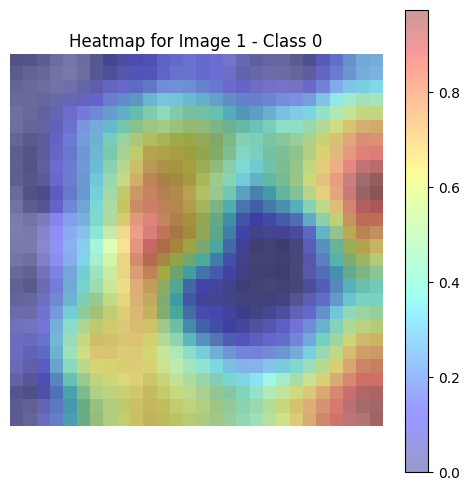

In [12]:
load_model_and_generate_heatmap('best_model.keras', image_index=1, layer_name='conv2d_3')

In [ ]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 28, 28, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 14, 14, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 14, 14, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 7, 7, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 7, 7, 32)            │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 4, 4, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 4, 4, 32)            │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 2, 2, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_max_pooling2d                 │ (None, 32)                  │               0 │
│ (GlobalMaxPooling2D)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 2)                   │              66 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 87,560 (342.04 KB)

 Trainable params: 29,186 (114.01 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 58,374 (228.03 KB)